In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import torch.utils.data
import numpy as np

In [2]:
from utils import Logger

In [3]:
transform1=transforms.Compose([transforms.Resize((500,500)),
                              
                            transforms.ToTensor()])
image_folder=datasets.ImageFolder(root=r'C:\Users\arpit14276\Desktop\Xray\Train_Images',transform=transform1)

In [4]:

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(image_folder, batch_size=50, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [5]:
# x,y=next(iter(data_loader))
# x.shape

In [6]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
       # n_features = 3000000
        n_out = 1
        
        self.hidden0 =  nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.hidden1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.hidden2 = nn.Conv2d(5, 1, kernel_size=3, stride=1, padding=1)
        self.hidden3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.hidden4=nn.Sequential(
            nn.Linear(15625, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden5 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden6 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        #print ('hidden0 ',x.size())
        x = self.hidden1(x)
        #print ('hidden1 ',x.size())
        x = self.hidden2(x)
        #print ('hidden2 ',x.size())
        x = self.hidden3(x)
        #print ('hidden3 ',x.size())
        x = self.hidden4(x.view(-1,15625))
        x = self.hidden5(x)
        x = self.hidden6(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [7]:
def images_to_vectors(images):
    return images.view(images.size(0), 3,500,500)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 500, 500)

In [8]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        
        self.hidden0 = nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1)
        self.hidden1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        
        self.hidden2 = nn.Conv2d(5, 3, kernel_size=3, stride=1, padding=1)
        self.out = nn.MaxPool2d(kernel_size=4, stride=1, padding=1)
        
        
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [9]:
def noise(size):
    '''
    Generates a 3-d vector of gaussian sampled random values
    '''
    x=torch.from_numpy(np.random.random(size=(size,3,500,500))).type(torch.FloatTensor)
    #print (x.type())
    n = Variable(x)
    return n

In [10]:
loss = nn.BCELoss()

In [11]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [12]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [13]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    #print ('real data size',N)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    #print ('predict dis',prediction_real)
    #print ('ones_tar',ones_target(N).size())
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [14]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error


In [15]:
num_test_samples = 4
test_noise = noise(num_test_samples)

torch.Size([50, 3, 500, 500])


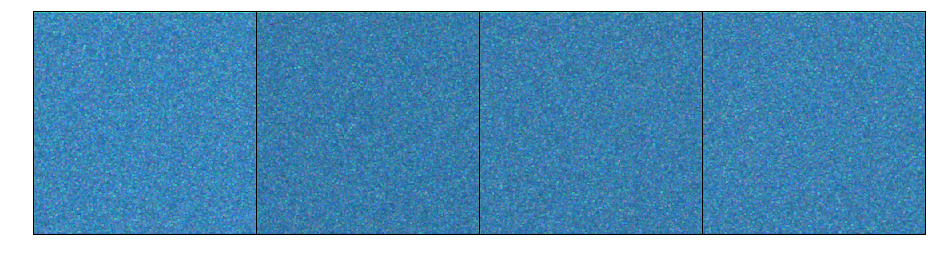

torch.Size([50, 3, 500, 500])


In [ ]:
logger = Logger(model_name='VGAN', data_name='MNIST')
num_epochs = 10
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        print (noise(N).shape)
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
           